# Inspecting DeepConsensus examples and running model

## Imports



Run these in order. These libraries are finicky about which order they're installed and loaded in.

In [ ]:
import tensorflow as tf

In [ ]:
! pip install deepconsensus==0.3.0

Looking in indexes: https://test.pypi.org/simple/, https://us-python.pkg.dev/colab-wheels/public/simple/, https://pypi.org/simple
     |████████████████████████████████| 145 kB 1.7 MB/s 
     |████████████████████████████████| 77 kB 4.0 MB/s 
     |████████████████████████████████| 1.6 MB 13.7 MB/s 
     |████████████████████████████████| 15.0 MB 10.8 MB/s 
     |████████████████████████████████| 2.1 MB 51.4 MB/s 
     |████████████████████████████████| 438 kB 78.3 MB/s 
     |████████████████████████████████| 48.3 MB 1.4 MB/s 
     |████████████████████████████████| 1.2 MB 61.4 MB/s 
     |████████████████████████████████| 636 kB 58.0 MB/s 
     |████████████████████████████████| 511.7 MB 7.9 kB/s 
     |████████████████████████████████| 43 kB 2.9 MB/s 
     |████████████████████████████████| 1.1 MB 52.8 MB/s 
     |████████████████████████████████| 92 kB 15.4 MB/s 
     |████████████████████████████████| 4.6 MB 61.5 MB/s 
     |████████████████████████████████| 352 kB 62.9 MB/s 
    

In [ ]:
# This will say "ERROR: Failed building wheel for google-nucleus", but that is fine, Nucleus will still work.
! pip install google-nucleus==0.5.9  # for visualization only
! pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.4 MB 1.0 MB/s 
  ERROR: Failed building wheel for google-nucleus
  Running setup.py clean for google-nucleus
Failed to build google-nucleus
    Running setup.py install for google-nucleus ... done
  DEPRECATION: google-nucleus was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import colorama
import numpy as np
import random
from deepconsensus.models import model_configs
from deepconsensus.models import model_utils
from deepconsensus.models import data_providers
from deepconsensus.utils import dc_constants
from nucleus.util import vis

## Define some useful visualization utilities

In [ ]:
def show_rows_for_one_example(rows, max_passes=20):
  """Break out the black/white matrix into subreads, ccs, PW, IP, etc.

  For each of `max_subreads`, we have four pieces of information: bases, PW, IP,
  and strand. We also have one row for CCS, and four rows for SN (in that
  order).
  The information is structured as follows:
  Bases: rows 0 to  (params.max_passes - 1)
  PW: rows (params.max_passes) to (params.max_passes * 2 - 1)
  IP: rows (params.max_passes * 2) to (params.max_passes * 3 - 1)
  Strand: rows (params.max_passes * 3) to (params.max_passes * 4 - 1)
  CCS+SN: rows (params.max_passes * 4) to (params.max_passes * 4 + 5)
  """
  print('bases:')
  vis.array_to_png(rows[0:max_passes])
  print('PW: pulse-width')
  pw = rows[max_passes:max_passes*2]
  vis.array_to_png(pw)
  print('IP: inter-pulse duration')
  ip = rows[max_passes*2:max_passes*3]
  vis.array_to_png(ip)

  print('Strand:')
  vis.array_to_png(rows[max_passes*3:-5])

  print('CCS:')
  ccs = rows[-5:-4]
  vis.array_to_png(ccs)
  print('SN:')
  sn = rows[-4:]
  vis.array_to_png(sn)

In [ ]:
def encoded_sequence_to_string(encoded_sequence):
  """Convert an encoded sequence (a series of integers) to a DNA string."""
  return ''.join([dc_constants.VOCAB[int(base)] for base in encoded_sequence])


def get_ccs_matrix(rows_for_one_example):
  """Slice the encoded CCS out of the 2d rows matrix of one example."""
  return rows_for_one_example[-5, :]


def get_ccs_seq(rows_for_one_example):
  """Get CCS string out of the 2d rows matrix of one example."""
  return encoded_sequence_to_string(get_ccs_matrix(rows_for_one_example))


def colorful(seq):
  """Add colors to a sequence of DNA."""
  fore = colorama.Fore
  background = colorama.Back
  colors = {
      'A': fore.GREEN,
      'C': fore.BLUE,
      'G': fore.YELLOW,
      'T': fore.RED,
      dc_constants.GAP_OR_PAD: background.WHITE
  }
  reset = fore.BLACK + background.RESET
  colored_seq = [f'{colors.get(base, reset)}{base}{reset}' for base in seq]
  return ''.join(colored_seq)


def show_example(batch, example_i, ypreds=None, max_passes=20):
  """Show an example with subreads, ccs, predictions, and labels."""
  batch_size = batch['rows'].shape[0]
  rows = batch['rows'][example_i, :, :, 0]
  ccs_i = get_ccs_seq(rows)
  print(f'Example: {example_i} of {batch_size} (batch)')
  print('How the sequences are represented for the model:')
  subreads = rows[0:max_passes, :]
  for subread_i in range(len(subreads)):
    print(f'Subread {subread_i + 1}\t',
          colorful(encoded_sequence_to_string(subreads[subread_i, :])))
  print('ccs:\t\t', colorful(ccs_i))
  if ypreds is not None:
    predicted_sequence = encoded_sequence_to_string(ypreds[example_i])
    print('prediction:\t', colorful(predicted_sequence))
  if 'label' in batch:
    label = encoded_sequence_to_string(batch['label'][example_i])
    print('label:\t\t', colorful(label))
  print('\n')


## Load the model

In [ ]:
! mkdir deepconsensus_model
! gsutil cp -r gs://brain-genomics-public/research/deepconsensus/models/v0.3/* deepconsensus_model/

Copying gs://brain-genomics-public/research/deepconsensus/models/v0.3/params.json...
Copying gs://brain-genomics-public/research/deepconsensus/models/v0.3/saved_model.pb...
Copying gs://brain-genomics-public/research/deepconsensus/models/v0.3/variables/variables.data-00000-of-00001...
Copying gs://brain-genomics-public/research/deepconsensus/models/v0.3/variables/variables.index...
- [4 files][ 38.2 MiB/ 38.2 MiB]                                                
Operation completed over 4 objects/38.2 MiB.                                     


In [ ]:
! gsutil cp gs://brain-genomics-public/research/deepconsensus/test_data/v0.3/tf-test-00001-of-00500.tfrecord.gz ./tf-test.tfrecord.gz

Copying gs://brain-genomics-public/research/deepconsensus/test_data/v0.3/tf-test-00001-of-00500.tfrecord.gz...
\ [1 files][122.4 MiB/122.4 MiB]                                                
Operation completed over 1 objects/122.4 MiB.                                    


In [ ]:
saved_model_path = 'deepconsensus_model/'
model = tf.saved_model.load(saved_model_path)
params = model_utils.read_params_from_json(checkpoint_path=saved_model_path)
model

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7f937f304c90>

# Load examples from tfrecords

In [ ]:
tfrecord_path = 'tf-test.tfrecord.gz'

# Number of examples:
batch_size = 20  #@param

ds = data_providers.get_dataset(tfrecord_path,
                                num_epochs=None,
                                batch_size=batch_size,
                                params=params,
                                inference=False)

# Just get one batch to inspect:
for batch in ds.take(1):
  break

keys = ['name', 'label', 'rows', 'num_passes', 'window_pos']
for key in keys:
  print(f'{key}.shape: {batch[key].shape}')

name.shape: (20, 1)
label.shape: (20, 120)
rows.shape: (20, 85, 120, 1)
num_passes.shape: (20, 1)
window_pos.shape: (20, 1)


## Visualize the rows of one example. This is what the model sees.

Rows is of shape `[batch_size, input_size, length, 1]`.

So when we take `rows[example_i,:,:,0]`, that is one example in the batch, and we get a 2D matrix (getting rid of the last dimension that was only a placeholder for model code).

Example: 9 of 20 (batch)
ZMW: b'm64062_190803_042216/394059/ccs'
window_pos: 5326 bp (where example starts within the CCS read)
num_passes: 5 subreads
What the model sees:


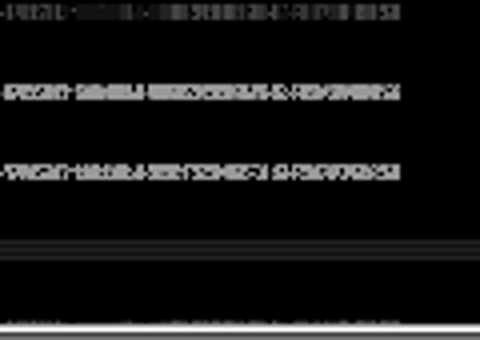

In [ ]:
example_i = int(random.random() * batch_size)

print(f'Example: {example_i} of {batch_size} (batch)')
print('ZMW:', batch['name'][example_i].numpy()[0])
print('window_pos:', int(batch['window_pos'][example_i].numpy()), 'bp (where example starts within the CCS read)')
print('num_passes:', int(batch['num_passes'][example_i]), 'subreads')
print('What the model sees:')
vis.array_to_png(batch['rows'][example_i,:,:,0])

### Let's break that down

Each matrix is composed of multiple data types layered in rows. The bases, pulse-width, inter-pulse duration, and strand are per-subread, up to the max number of subreads (this is in params.max_passes, which as of DeepConsensus v0.3 is 20). The input also contains a draft circular consensus sequence (CCS) from PacBio and the signal-to-noise ratio (SN).

Example: 9 of 20 (batch)
bases:


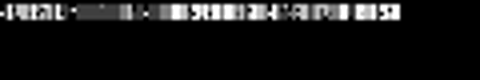

PW: pulse-width


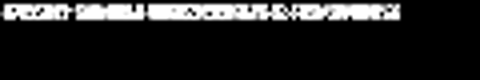

IP: inter-pulse duration


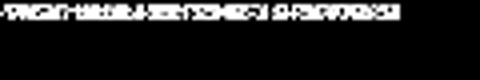

Strand:


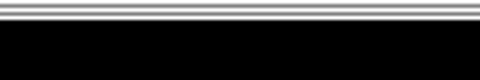

CCS:


SN:


In [ ]:
print(f'Example: {example_i} of {batch_size} (batch)')
show_rows_for_one_example(rows=batch['rows'][example_i,:,:,0])

# Run the model

Run the model on `rows`, which is the input data for the model that we visualized above.

In [ ]:
softmax_output = model.signatures['serving_default'](batch['rows'])
softmax_output = softmax_output['output_1'].numpy()
print(softmax_output.shape)

(20, 120, 5)


In [ ]:
y_preds = np.argmax(softmax_output, -1)
print(y_preds.shape)

(20, 120)


### Interpreting y_preds output

In [ ]:
prediction = y_preds[example_i]
print(f'Prediction for example {example_i}:')
print(prediction)
print('Which translates to:')
print(encoded_sequence_to_string(prediction))

Prediction for example 9:
[0 1 4 1 3 3 3 2 4 2 3 2 3 1 4 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 3 1 1 1 0
 1 1 1 2 2 2 4 4 3 3 1 4 4 3 4 2 4 4 2 4 4 3 2 3 1 3 4 3 3 2 0 4 2 1 1 0 2
 3 3 3 1 2 3 1 3 2 2 2 4 4 1 1 4 4 3 3 4 1 4 4 3 4 4 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]
Which translates to:
 AGACCCTGTCTCAGAA  AAAAAAAAAAATTCAAA AAATTTGGCCAGGCGTGGTGGCTCACGCCT GTAA TCCCATCACTTTGGAAGGCCGAGGCGG                    


In [ ]:
print('For reference, the alphabet is:')
print('\n'.join([f'{i} -> "{s}"' for i,s in enumerate(dc_constants.VOCAB)]))

For reference, the alphabet is:
0 -> " "
1 -> "A"
2 -> "T"
3 -> "C"
4 -> "G"


# Visualize example sequences alongside prediction and label

In [ ]:
show_example(batch, example_i, ypreds=y_preds)

Example: 9 of 20 (batch)
How the sequences are represented for the model:
Subread 1	                                                                                                                         
Subread 2	  AGACCCTGTCGCAGAA  AAAAAATAAAATTC AA AAATTTGGCCAGGCGTGGTGGCTCACGCCT GTAC TCCCATCCCTTTGGAAGGCCGAGGCGG                    
Subread 3	  AG CCCTGT TCAGAAAGAAAAAAAAAAATTC AA AAATTTGGCC GGCGTGGTGGCTCA GCCT GT A T CCATCACTTTGGAAGGCCGAGG GG                    
Subread 4	 GAGACCCAG CTCAG A  AAAAAAAAAAATTCAAAGAAATTTGGCCA GCG GGTGGCACACGCCTGGTAATTCCCATCACATTGGAAGCCCGA GCGG                    
Subread 5	  AGA CCTGTCTCAGCA  AAAAAAAAAAATTCAAA AAATTTGGCCAGGAGTGGTGGCTCACGCCT GTAA T CCATCA TTTGG AGGCCGAGGCGG                    
Subread 6	                                                                                                                         
Subread 7	                                                                                                                         
Su